In [2]:
# Scientific libraries
import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style(context='talk', fscale=1,grid=False)
import seaborn as sns

import pystan
import stan_utility

from vapeplot import vapeplot

light="#DCBCBC"
light_highlight="#C79999"
mid="#B97C7C"
mid_highlight="#A25050"
dark="#8F2727"
dark_highlight="#7C0000"
green="#00FF00"

vapeplot.set_palette('sunset')

# Systematic error and rounding

Suppose we make repeated measurements of weight, length, etc. and the measurements are rounded to the nearest integer value. We want to know the exact value of the object.

Here are the values we have measured:



<IPython.core.display.Javascript object>


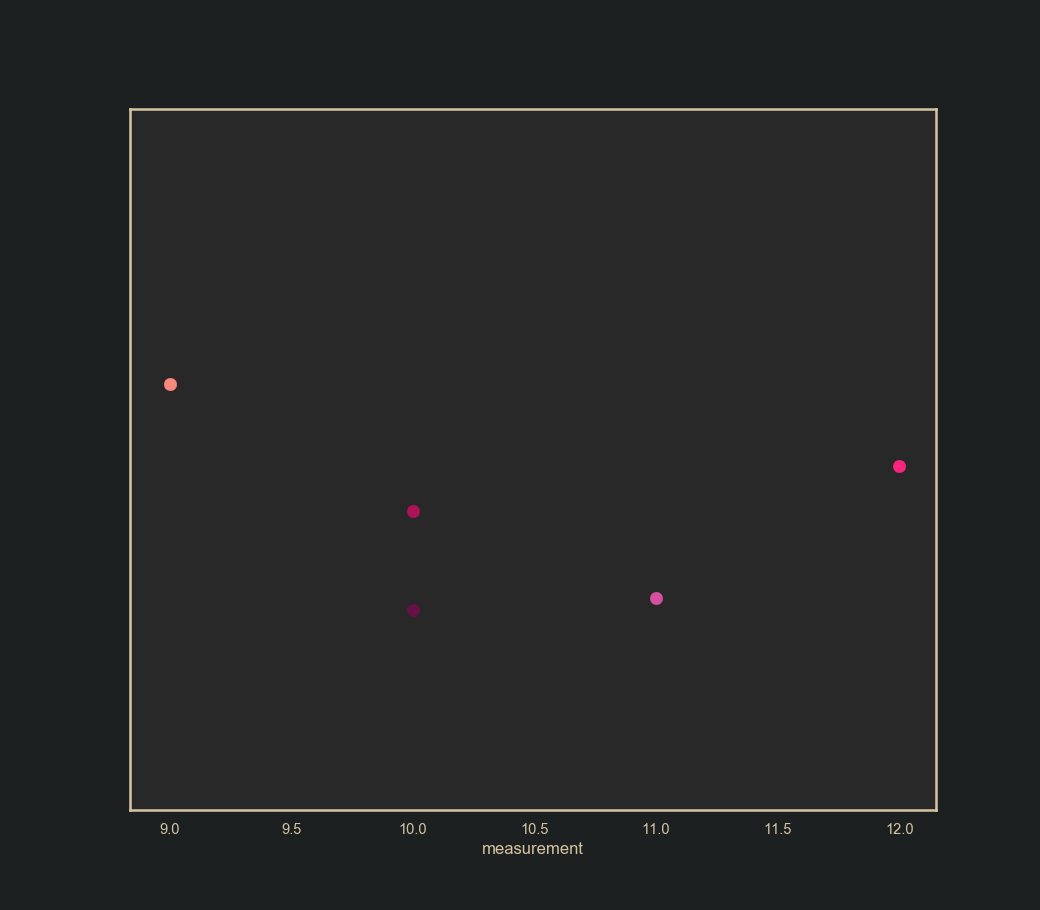

In [4]:
obs = np.array([10,10,12,11,9])

data = dict(y=obs, N=len(obs))



fig, ax = plt.subplots()

for y in obs:
    
    
    ax.scatter(y, 1+np.random.normal(0,.05),zorder=0)

ax.set_xlabel('measurement')

ax.set_ylim(.8,1.2)
ax.set_yticks([])

fig.savefig('measurement.pdf',bbox_inches='tight')

## Treat the data as unrounded

We can first treat the measurements as if they are not rounded and fit them to a normal distribution. With Stan, the model looks like this:

```c++
data {
  int<lower=0> N; // number of measurments
  vector[N] y; // repeated observations
}
parameters {
  real mu; // mean
  real<lower = 0> sigma; //width
}

model {
  // measurement model
  // uninformative priors on mu and sigma
  y ~ normal(mu, sigma);

}


```


This is simply equivalent to:

$$ y_{\rm obs} \sim \mathcal{N}\left(\mu, \sigma \right)$$


Now we can compiled the model and fit.

In [60]:
model_unrounded = stan_utility.compile_model('treat_unrounded.stan')


Using cached StanModel


In [63]:
fit_unrounded = model_unrounded.sampling(data=data, iter=2000, seed=12314234)

Let's examine the distribution of $\mu$ and $\sigma$. We will actually cut off the tails a bit because they are wide.

<IPython.core.display.Javascript object>


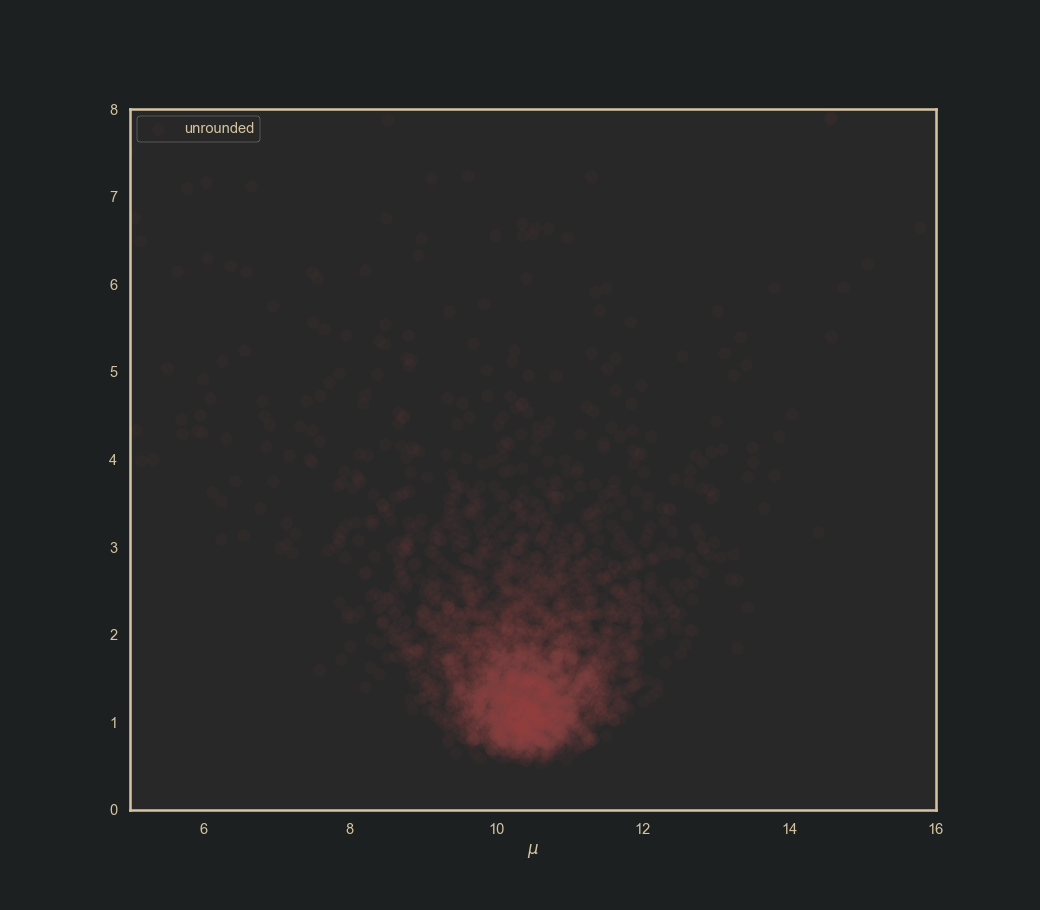

In [113]:
fig, ax = plt.subplots()
ax.scatter(fit_unrounded.extract()['mu'],fit_unrounded.extract()['sigma'],alpha=0.05, c=mid_highlight, label='unrounded')


ax.set_xlim(5,16)
ax.set_ylim(0,8)

ax.legend()

ax.set_xlabel(r'$\mu$')
fig.savefig('unrounded.pdf',bbox_inches='tight')

## Treat the data as rounded

Now we will treat the measurements as if they have been rounded, but we do not know in which direction and what the error distribution would be.

Instead of adding and arbitrary $\pm \sigma$ to the posterior, we introduce latent rounding error that we will fit (model) and let the data speak for themselves.


In math, this is:

$$ z = y_{\rm obs} + \sigma_{\rm round} $$

$$ z \sim \mathcal{N}\left(\mu, \sigma \right)$$

and in code:

```c++

data {
  int<lower=0> N; // number of measurements
  vector[N] y; // repeated measurements
 }
parameters {
  real mu; //mean
  real<lower=0> sigma_sq; // width
  vector<lower=-0.5, upper=0.5>[N] y_err; // measurement error from rounding
}
transformed parameters {
  real<lower=0> sigma;
  vector[N] z;

  sigma = sqrt(sigma_sq);
  // the latent value of the measurement
  z = y + y_err;
}
model {

  // measurement model
  target += -2 * log(sigma);
  z ~ normal(mu, sigma);
}


```

Let's compile the model and fit it.

In [61]:

model_rounded = stan_utility.compile_model('treat_rounded.stan')

Using cached StanModel


In [67]:
fit_rounded = model_rounded.sampling(data=data, iter=2000,seed=12314234)

Now we can look at the posterior distribution of this fit. It looks almost similar

<IPython.core.display.Javascript object>


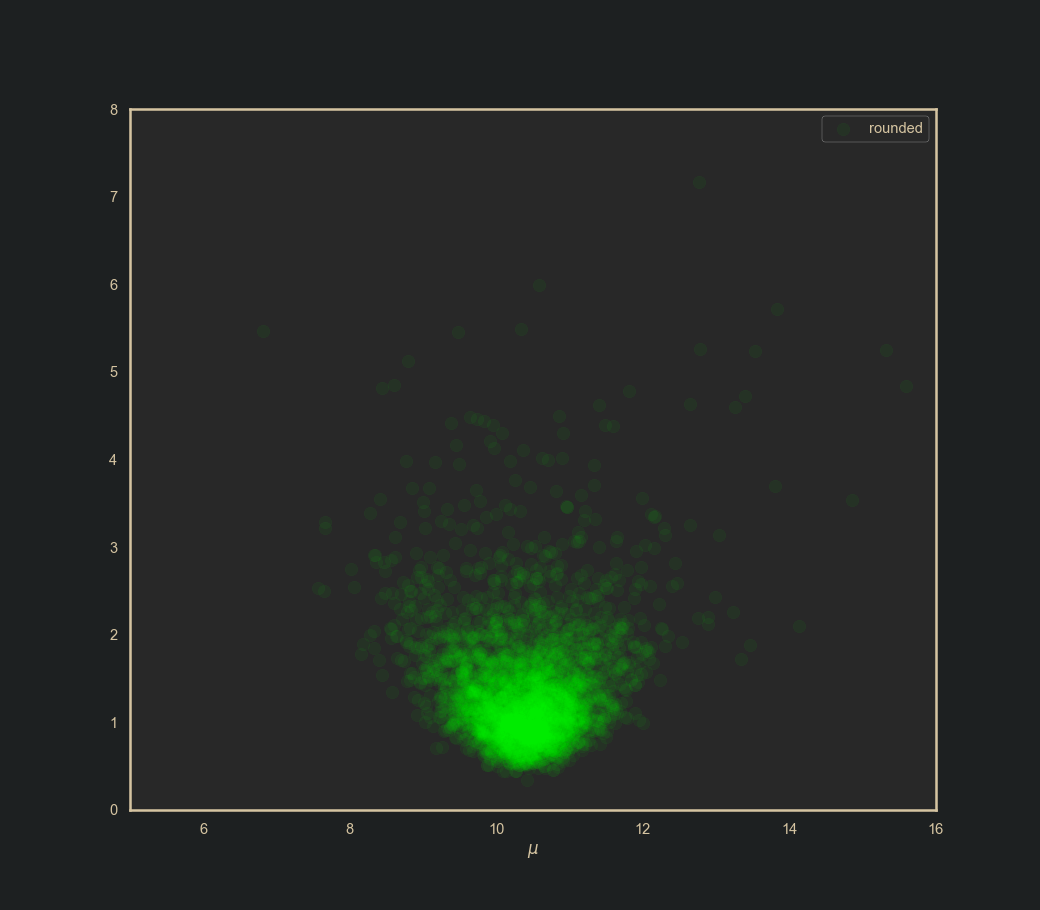

In [112]:
fig, ax = plt.subplots()

ax.scatter(fit_rounded.extract()['mu'],fit_rounded.extract()['sigma'],alpha=0.05, c=green, label='rounded')


ax.set_xlim(5,16)
ax.set_ylim(0,8)

ax.legend()

ax.set_xlabel(r'$\mu$')
fig.savefig('rounded.pdf',bbox_inches='tight')

But when we compare to our first model, we can see that the posterior for the rounded model is wider. In other words, the systematic is *naturally* included into our estimates.

<IPython.core.display.Javascript object>


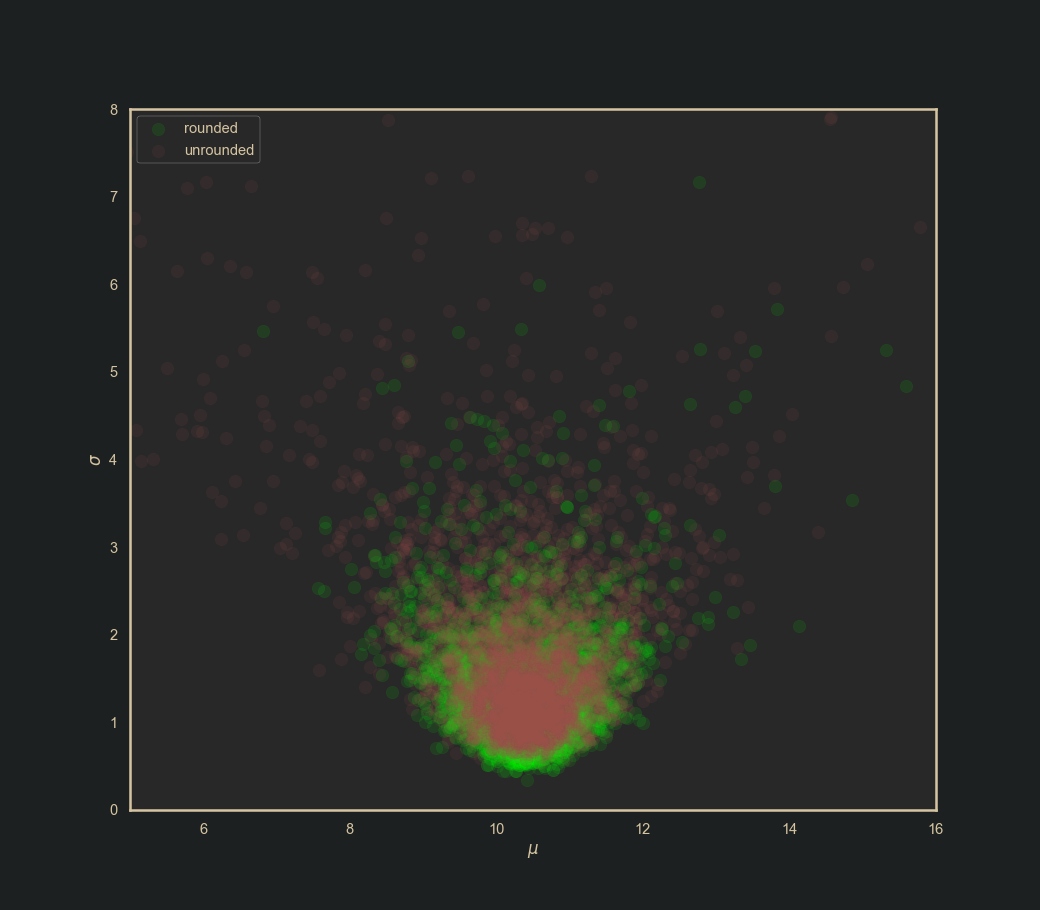

In [111]:
fig, ax = plt.subplots()

ax.scatter(fit_rounded.extract()['mu'],fit_rounded.extract()['sigma'],alpha=0.1, c=green, label='rounded')
ax.scatter(fit_unrounded.extract()['mu'],fit_unrounded.extract()['sigma'],alpha=0.1, c=mid_highlight, label='unrounded')


ax.set_xlim(5,16)
ax.set_ylim(0,8)

ax.legend()

ax.set_xlabel(r'$\mu$')
ax.set_ylabel(r'$\sigma$')

fig.savefig('round_compare.pdf',bbox_inches='tight')

We can look at the posterior of our latent measurements to see what is going on. The model pulls measurements to the mean, while still respecting the bounds of rounding. 

<IPython.core.display.Javascript object>


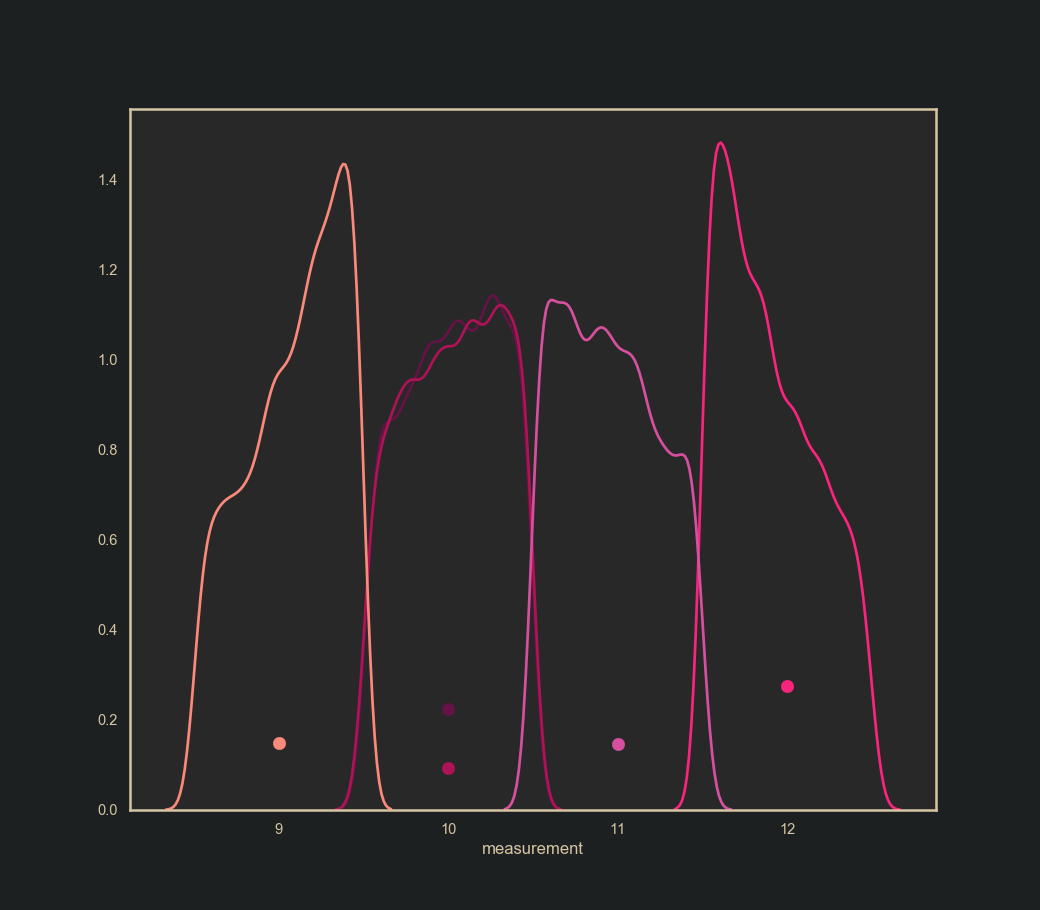

In [131]:
np.random.seed(345)
z = fit_rounded.extract()['z']

fig, ax = plt.subplots()

for zz in z.T:
    
    sns.distplot(zz,hist=False)
for y in obs:
    
    
    ax.scatter(y, 0.15+np.random.normal(0,.05),zorder=0)

ax.set_xlabel('measurement')


fig.savefig('measurement_error.pdf',bbox_inches='tight')